# Variational Inference API Quickstart

PyMC4 now comes integrated with tensorflow probability to use Variational Inference approximations.

- Mean Field ADVI - Implemented
- Full Rank ADVI - Coming Soon
- Low Rank ADVI - Coming Soon

For a more exhaustic introduction to VI, checkout this [blog post](https://www.codingpaths.com/gsoc/variational-inference/).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from pprint import pprint

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

Let's infer $\mu$ and $\sigma$ for Normal Distribution

In [3]:
# Generating data
MU = 12
SIGMA = 2.2
data = np.random.normal(MU, SIGMA, 200)

In [4]:
@pm.model
def model():
    mu = yield pm.Normal("mu", 0, 10)
    sigma = yield pm.Exponential("sigma", 1)
    ll = yield pm.Normal("ll", mu, sigma, observed=data)
    return ll

In [5]:
approx_model = model()

In [6]:
help(pm.fit)

Help on function fit in module pymc4.variational.approximations:

fit(model: Union[pymc4.coroutine_model.Model, NoneType] = None, method: Union[str, pymc4.variational.approximations.MeanField, pymc4.variational.approximations.FullRank] = 'advi', num_steps: int = 10000, sample_size: int = 1, random_seed: Union[int, NoneType] = None, optimizer=None, **kwargs)
    Fit an approximating distribution to log_prob of the model.
    
    Parameters
    ----------
    model : Optional[:class:`Model`]
        Model to fit posterior against
    method : Union[str, :class:`Approximation`]
        Method to fit model using VI
    
        - 'advi' for :class:`MeanField`
        - 'fullrank_advi' for :class:`FullRank`
        - 'lowrank_advi' for :class:`LowRank`
        - or directly pass in :class:`Approximation` instance
    num_steps : int
        Number of iterations to run the optimizer
    sample_size : int
        Number of Monte Carlo samples used for approximation
    random_seed : Optional

In [7]:
mean_field = pm.fit(approx_model, num_steps=40000)

Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


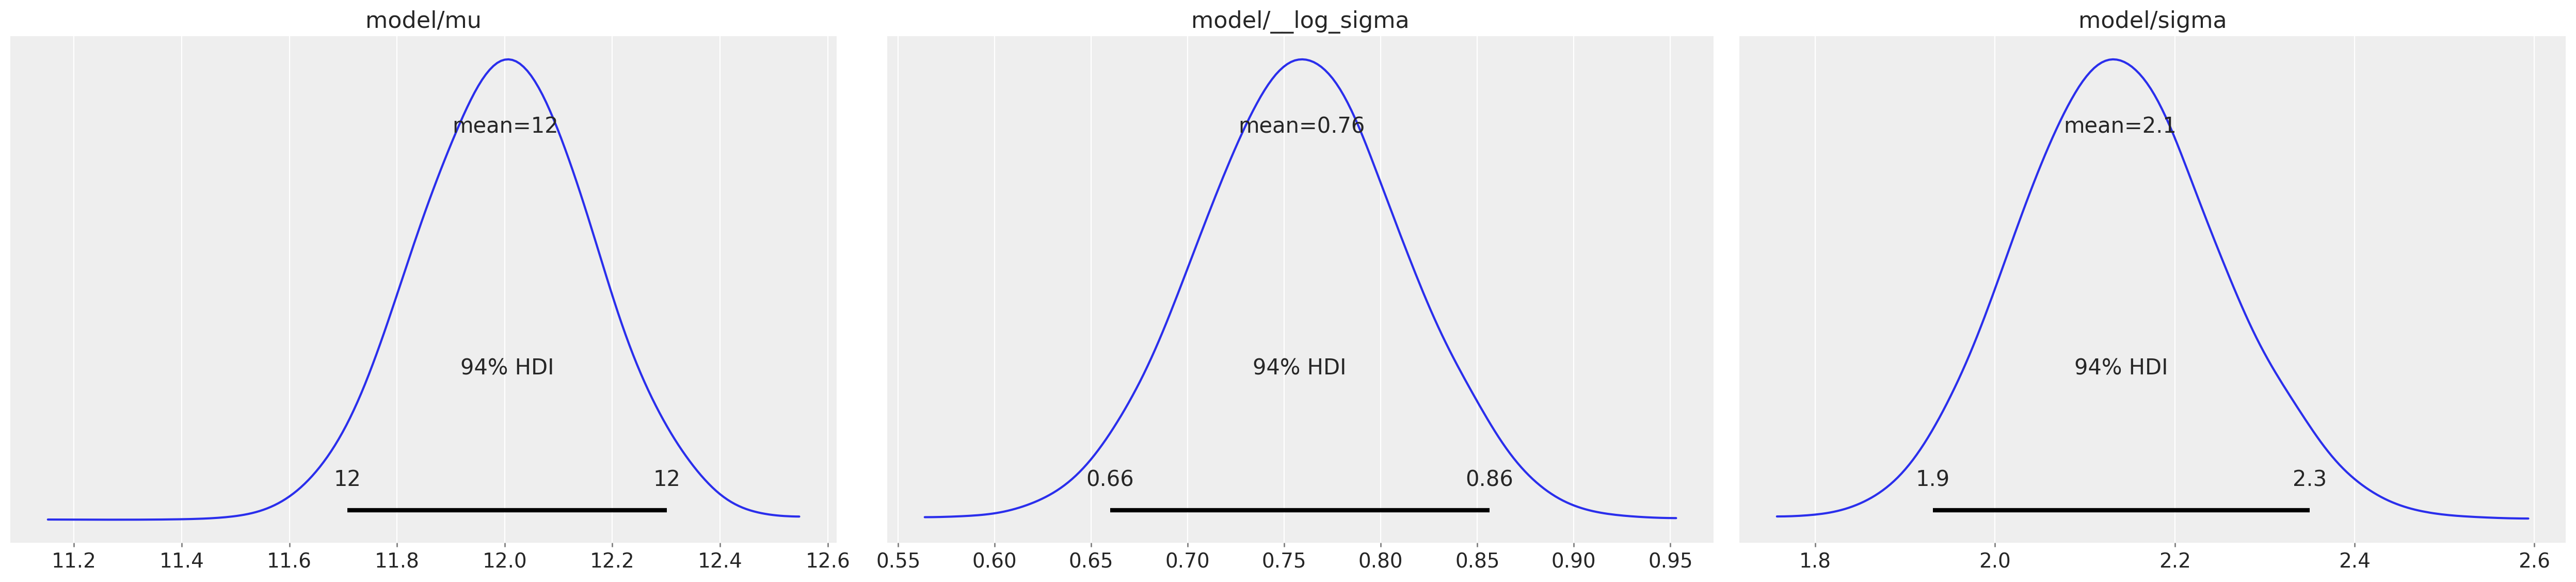

In [8]:
az.plot_posterior(mean_field.approximation.sample(10000));

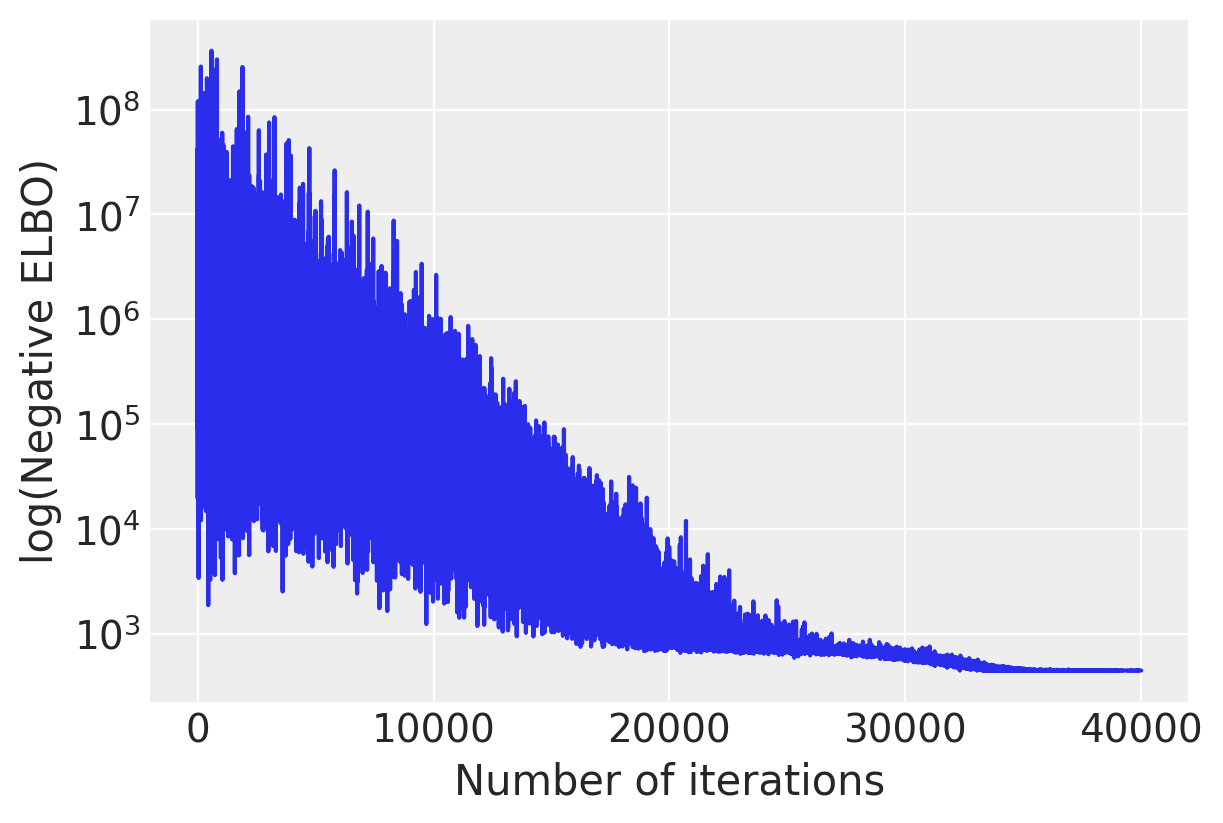

In [9]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, xlabel="Number of iterations", ylabel="log(Negative ELBO)")
ax.plot(mean_field.losses)
ax.set_yscale("log");

ELBO seems to have converged.

## Parameter Tracking

This is similar to `callbacks` in PyMC3.

In [10]:
approx_model = model()
advi = pm.MeanField(approx_model)

In [11]:
# Useful for NUTS sampling
pprint([advi.approx.mean(), advi.approx.stddev()])

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.6532107, -1.9251096], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>]


In [12]:
advi.trainable_variables
# advi.approx.shared_params in PyMC3

(<tf.Variable 'mu:0' shape=(2,) dtype=float32, numpy=array([ 0.6532107, -1.9251096], dtype=float32)>,
 <tf.Variable 'sigma:0' shape=(2,) dtype=float32, numpy=array([0.54132485, 0.54132485], dtype=float32)>)

Recall for Mean Field ADVI, we approximate each parameter by Gaussian Distribution in unbounded space.

In [13]:
# track dict
track = dict()
for param in advi.trainable_variables:
    track[param.name] = param

In [14]:
# Let's build a trace function
def trace_fn(traceable_quantities):
    return {"loss": traceable_quantities.loss, **track}

In [15]:
mean_field = pm.fit(num_steps=40000, method=advi, trace_fn=trace_fn)

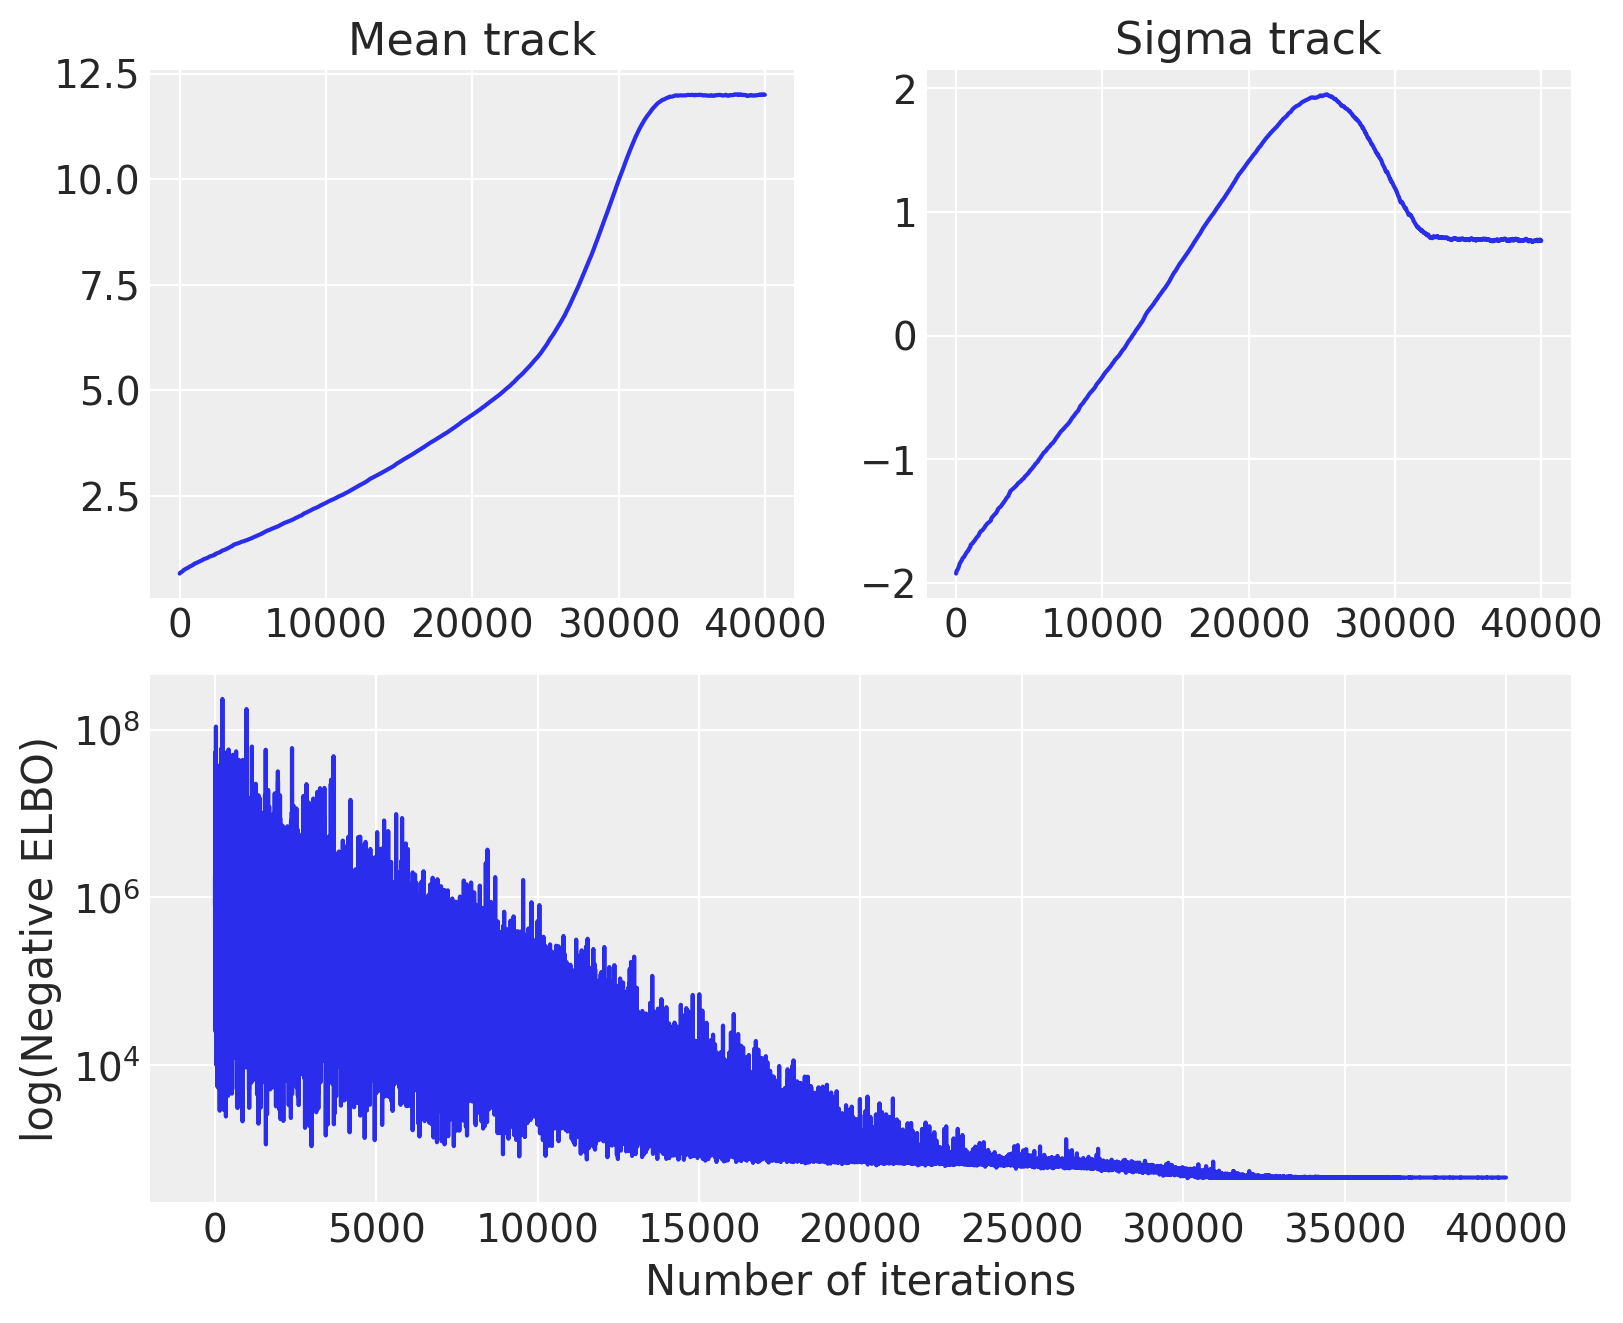

In [16]:
approximated_mu = mean_field.losses['mu:0'][:, 0]
approximated_sigma = mean_field.losses['mu:0'][:, 1]
loss = mean_field.losses["loss"]

fig = plt.figure(figsize=(8, 6.5))
gs = fig.add_gridspec(2, 2)
mu_track = fig.add_subplot(gs[0, 0])
sigma_track = fig.add_subplot(gs[0, 1])
elbo_track = fig.add_subplot(gs[1, :])

mu_track.plot(approximated_mu)
mu_track.set_title("Mean track")
sigma_track.plot(approximated_sigma)
sigma_track.set_title("Sigma track")
elbo_track.plot(loss)
elbo_track.set_xlabel("Number of iterations")
elbo_track.set_ylabel("log(Negative ELBO)")
elbo_track.set_yscale("log")

In [17]:
advi.trainable_variables

(<tf.Variable 'mu:0' shape=(2,) dtype=float32, numpy=array([11.996743  ,  0.76967716], dtype=float32)>,
 <tf.Variable 'sigma:0' shape=(2,) dtype=float32, numpy=array([-1.7859366, -2.9385538], dtype=float32)>)

We got pretty close estimates to $\mu$ and $\sigma$. Also, the parameter $\sigma$ needs to transformed via exp and that will be close to 2.2

### TODO - Add a convergence_criterion example

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

seaborn                0.10.1
numpy                  1.18.5
pymc4                  4.0a2
tensorflow             2.4.0-dev20200711
tensorflow_probability 0.11.0-dev20200711
arviz                  0.9.0
last updated: Tue Jul 14 2020 

CPython 3.7.7
IPython 7.16.1
watermark 2.0.2
